# User-Defined Processes (UDP) in openEO
 
openEO allows processes to be chained together in a *process graph* to build a particular algorithm.
Often, users have specific (sub)graphs that reoccur in the same process graph or even in different process graphs or algorithms.
openEO back-ends allows you to store such subgraphs as so-called "User-Defined Process" (often abbreviated as UDP),
and build your library of reusable openEO building blocks.

This notebook provides a step-by-step guide on how to create and use a User-Defined Process,
for with a Normalized Difference Water Index (NDWI) use case.

## Set up

Import a couple of packages and establish an authenticated connection

In [4]:
import json
import openeo
from openeo.api.process import Parameter

In [5]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

## Building a parameterized datacube

The openEO Python client lets you define parameters as `Parameter` instances (from `openeo.api.process` subpackage).
In general you have to specify at least the parameter name, a description and a schema.

In [6]:
temporal_extent_param = Parameter(
    name="date_range",
    description="The date range to load.",
    schema={"type": "array", "subtype": "temporal-interval"},
)

spatial_extent_param = Parameter(
    name="bbox",
    description="The bounding box to load.",
    schema={"type": "object", "subtype": "geojson"},
)

Use the parameters directly as arguments to `load_collection` to build in initial data cube with `SENTINEL2_L2A` data.

In [7]:
band = ["B03", "B08"]
cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_param,
    spatial_extent=spatial_extent_param,
    bands=band,
    max_cloud_cover=80,
)

The NDWI is a vegetation index sensitive to the water content of vegetation and is complementary to the NDVI. High NDWI values show a high water content of the vegetation.
$$ \mathrm{NDWI} = \frac{\mathrm{Green} - \mathrm{NIR}}{\mathrm{Green} + \mathrm{NIR}} $$

In [8]:
green = cube.band("B03")
nir = cube.band("B08")

ndwi = (green - nir) / (green + nir)
ndwi

Now, let's produce a temporal aggregation by taking the temporal maximum value.

In [9]:
ndwi = ndwi.max_time()

## Store as User-Defined Process (UDP)

We can now store this parametarized data cube representation as a user-defined process called NDWI on the back-end.

In [10]:
connection.save_user_defined_process(
    user_defined_process_id="NDWI",
    process_graph=ndwi,
    parameters=[temporal_extent_param, spatial_extent_param],
)

## Use the UDP

Now, let’s evaluate our freshly created user-defined processes "NDWI".
We can using `datacube_from_process()` to create a `DataCube` from this process
and only have to provide concrete temporal and spatial extents:

In [13]:
ndwi2022 = connection.datacube_from_process(
    process_id="NDWI",
    date_range=["2022-07-19", "2022-07-19"],
    bbox={"west": 5.09, "south": 51.18, "east": 5.15, "north": 51.21},
)

In [14]:
ndwi2022.download("ndwi2022.tiff")

### Visualize the result

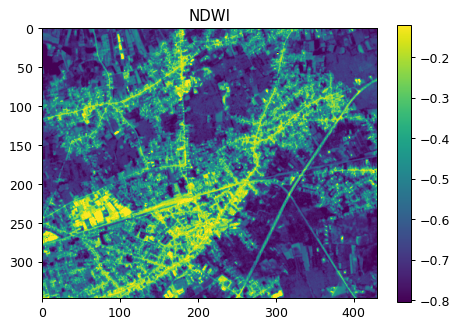

In [15]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

data = rasterio.open("ndwi2022.tiff").read()

fig, ax = plt.subplots(figsize=(6, 4), dpi=90)
img = ax.imshow(data[0], vmin=np.percentile(data, 1), vmax=np.percentile(data, 99))
ax.set_title("NDWI")
plt.colorbar(img)